In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import pickle
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import permutation_test, binomtest

In [2]:
# read survey data and submission data from files, NOTE: these files are not included in the repository so the code will not run correctly
df_pre = pd.read_csv('clean_data/pre_survey_final.csv') # registration survey data
df_sub = pd.read_csv('clean_data/submissions_final.csv') # checklist submissions 
df_post = pd.read_csv('clean_data/post_survey_final.csv') # post-usage survey data

In [3]:
df_pre.shape[0], df_sub.shape[0], df_post.shape[0]

(773, 234, 78)

## Analyze LLM Responses

In [4]:
df_sub['zip_name'] = 'clean_data/'+ df_sub['zip_name']

# extract checklist data from zip files
def extract_checklist(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open("paper_checklist.csv") as f:
            return pd.read_csv(f)

# extract paper parse data from zip files
def extract_paper_parse(zip_path):
     with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open("article_dict.pickle") as f:
            return pickle.load(f)
        
sub_ids = df_sub['submission_id']
checklists = df_sub['zip_name'].apply(extract_checklist)
df_checklists = pd.DataFrame()
for sub_id, d in zip(sub_ids, checklists):
    d['submission_id'] = sub_id
    df_checklists = pd.concat([df_checklists, d])
df_checklists = df_checklists.reset_index(drop=True)

# map question titles to shorter names
q_map = {
    'Claims': 'Claims',
    'Limitations': 'Limitations',
    'Theoretical assumptions and proofs': 'Theory',
    'Experiments reproducibility': 'Reproducibility',
    'Code and data accessibility': 'Code and data',
    'Experimental settings/details': 'Experimental details',
    'Error bars': 'Error bars',
    'Compute resources': 'Compute resources',
    'NeurIPS code of ethics': 'Code of ethics',
    'Impacts': 'Impacts',
    'Safeguards': 'Safeguards',
    'Credits': 'Credits',
    'Documentation': 'Documentation',
    'Human subjects': 'Human subjects',
    'Risks': 'Risks',
}

N_QUESTIONS = len(q_map)

df_checklists['Question_Title_Short'] = df_checklists['Question_Title'].map(q_map)
q_order = df_checklists[df_checklists.submission_id == 62277].Question_Title_Short

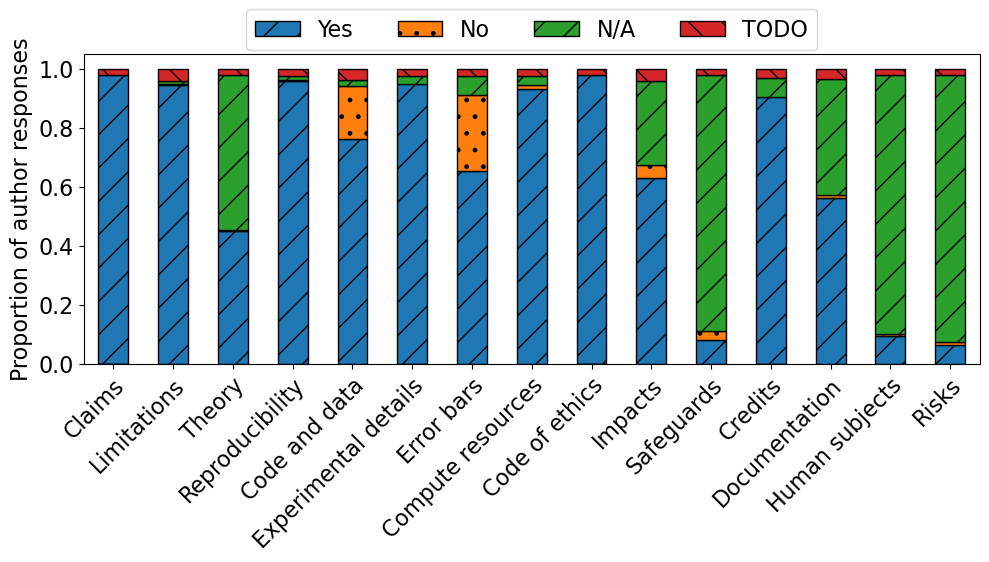

In [5]:
# Get distribution of author answers to each question
# replace 'Not Applicable' with 'N/A' as answer
df_checklists['Answer'] = df_checklists['Answer'].replace('Not Applicable', 'N/A')
author_answers = df_checklists[df_checklists.Answer != 'Not Found'].groupby('Question_Title_Short')['Answer'].value_counts(normalize=True).unstack().fillna(0)
author_answers = author_answers.loc[q_order, ['Yes', 'No', 'N/A', 'TODO']]

author_answers.plot(kind='bar', stacked=True, figsize=(10, 6), edgecolor='black')
# make different hatches for each answer
bars = plt.gca().patches
hatches = ''.join(h*len(author_answers) for h in ['/', '.', '/', '\\'])
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

# put legend in center above plot 
plt.legend(title='', ncol = 4, loc='upper center', bbox_to_anchor=(0.5, 1.18), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('') 
plt.ylabel('Proportion of author responses', fontsize=16)
plt.xticks(rotation=45, fontsize=16, ha='right', rotation_mode='anchor')

# properly align rotated x-axis labels
plt.tight_layout()
plt.show()

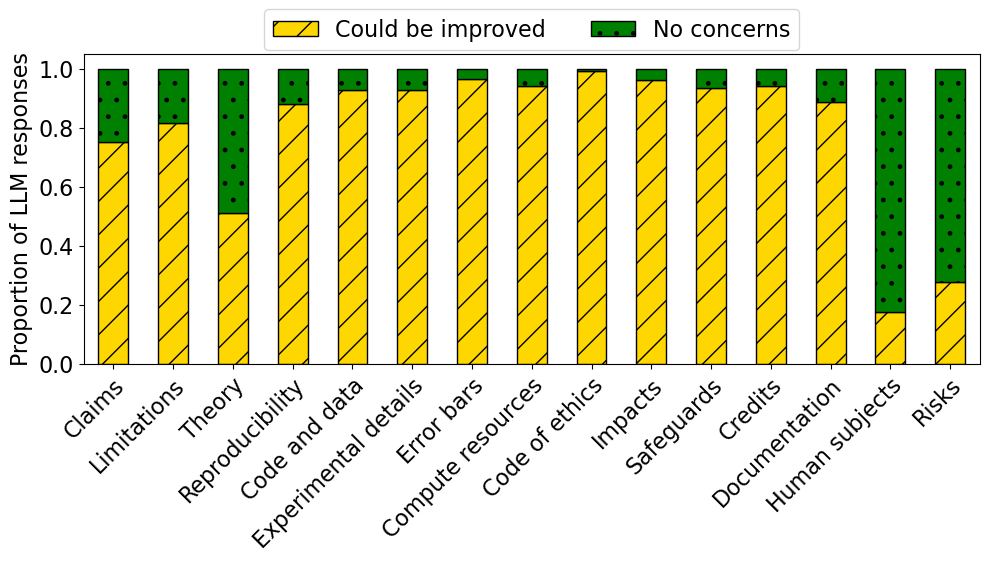

In [6]:
# Get distribution of LLM responses to each question
df_checklists['Score'] = df_checklists['Score'].replace(0.5, 0)
llm_scores = df_checklists[df_checklists.Score >= 0].groupby(['Question_Title_Short'])['Score'].value_counts(normalize=True).unstack()
# order by Question_Title q_order
llm_scores = llm_scores.loc[q_order]
# make colors red, dark yellow, green
llm_scores.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#FFD700', '#008000'], edgecolor='black')

bars = plt.gca().patches
hatches = ''.join(h*len(llm_scores) for h in ['/', '.'])
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

# put legend in center above plot 
plt.legend(['Could be improved', 'No concerns'], title='', ncol = 3, loc='upper center', bbox_to_anchor=(0.5, 1.18), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('') 
plt.ylabel('Proportion of LLM responses', fontsize=16)
plt.xticks(rotation=45, fontsize=16, ha='right', rotation_mode='anchor')
# properly align rotated x-axis labels
plt.tight_layout()
plt.show()

# Analyze Survey Responses

In [7]:
df_survey = pd.merge(df_pre, df_post, on ='participant_id', how='inner', suffixes=('_pre', '_post'))
# take first survey answer from post survey if multiple responses
df_survey1 = df_survey.sort_values(by='ts_submission').groupby('participant_id').head(1).reset_index(drop=True)  

RESPONSE_MAP =  {
    'Strongly Disagree': -2,
    'Disagree': -1,
    'Agree': 1,
    'Strongly Agree': 2
}

QUESTIONS = ['modify', 'accurate', 'useful', 'excited']

In [8]:
responses = {}
for q in QUESTIONS:
    q_pre = q + '_question_pre'
    q_post = q + '_question_post'
    d = df_survey1[[q_pre, q_post]].copy()
    d = d[d[q_pre].notna() & d[q_post].notna()]
    pre = sum(d[q + '_question_pre'].map(RESPONSE_MAP) > 0)
    post = sum(d[q + '_question_post'].map(RESPONSE_MAP) > 0)
    n = d.shape[0]
    print(f'{q} pre: {pre}/{n}, post: {post}/{n}')
    responses[q] = {'pre': pre, 'post': post, 'n': n}

modify pre: 54/65, post: 46/65
accurate pre: 48/63, post: 36/63
useful pre: 59/65, post: 46/65
excited pre: 57/63, post: 42/63


sample size: 63


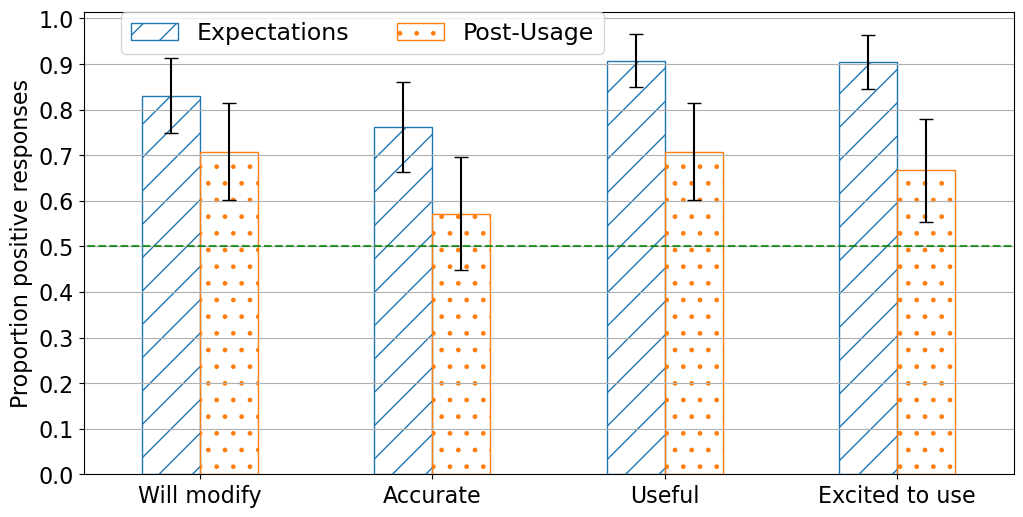

In [9]:
df_plot = pd.DataFrame(responses).T
# plot proportion of positive responses for each question as barplot
df_plot['pre'] = df_plot['pre'] / df_plot['n']
df_plot['post'] = df_plot['post'] / df_plot['n']
# error bar


df_plot['pre_err'] = proportion_confint(df_plot['pre']*df_plot['n'], df_plot['n'], alpha=0.05, method='beta')[1] - df_plot['pre']
df_plot['post_err'] = proportion_confint(df_plot['post']*df_plot['n'], df_plot['n'], alpha=0.05, method='beta')[1] - df_plot['post']
df_plot.plot(kind='bar', y=['pre', 'post'], figsize=(12, 6), color=['#1f77b4', '#ff7f0e'], yerr=df_plot[['pre_err', 'post_err']].T.values, capsize=5)
plt.ylabel('Proportion positive responses', fontsize=16)
# plt.xlabel('Question', fontsize=14)
plt.xticks(rotation=0, fontsize=16)
# set xtick labels
plt.xticks(range(4), ['Will modify', 'Accurate', 'Useful', 'Excited to use'], fontsize=16)
plt.yticks(np.arange(0,1.1, 0.1),fontsize=16)
# add y grid lines
plt.grid(axis='y')


# change hatching for pre vs post
bars = plt.gca().patches
hatch = ['/', '.']
for bar, h in zip(bars, hatch[0]*4 + hatch[1]*4):
    bar.set_hatch(h)
    # make hatches same color as bar fill and remove bar fill
    bar.set_edgecolor(bar.get_facecolor())
    bar.set_facecolor('none')
leg = plt.legend(['Expectations', 'Post-Usage'], fontsize=17, handlelength=2, ncol=2, bbox_to_anchor=(0.3, 1.026), loc='upper center')
plt.hlines(0.5, xmin=-1, xmax=4, color='green', ls='--', alpha=0.8)

print('sample size:', min(df_plot['n']))

plt.show()

In [10]:
binomtests = {}
pvalues = {}
# test whether each question is > 0.5 using binomial test
for q, r in responses.items():
    binomtests[q] = binomtest(r['post'], r['n'], 0.5, alternative='greater')
    pvalues[q] = binomtests[q].pvalue

# apply benjamini-hochberg correction
pvalues = pd.Series(pvalues).sort_values() + np.random.rand(len(pvalues))*1e-10
adjusted_pvalues = pvalues * len(pvalues) / pvalues.rank()
critical_vals = pvalues.rank() / len(pvalues) * 0.05

In [11]:
adjusted_pvalues

modify      0.002180
useful      0.001090
excited     0.007428
accurate    0.156752
dtype: float64

In [12]:
# make responses into binary 0s and 1s
responses_binary = {
    q: {'pre': r['pre']*[1] + (r['n'] - r['pre'])*[0], 'post': r['post']*[1] + (r['n'] - r['post'])*[0]}
    for q, r in responses.items()
}

# permutation test for each question
perms = {}
for q, r in responses_binary.items():
    perms[q] = result = permutation_test((r['pre'], r['post']), 
                          statistic=lambda x, y: np.mean(x) - np.mean(y), 
                          n_resamples=50000, 
                          alternative='two-sided')

    pvalues[q] = perms[q].pvalue

# apply benjamini-hochberg correction
pvalues = pd.Series(pvalues).sort_values()
critical_vals = pvalues.rank() / len(pvalues) * 0.05
adjusted_pvalues = pvalues * len(pvalues) / pvalues.rank()

In [13]:
perms

{'modify': PermutationTestResult(statistic=0.12307692307692308, pvalue=0.14175716485670287, null_distribution=array([ 0.06153846, -0.03076923,  0.03076923, ...,  0.        ,
        -0.12307692,  0.15384615])),
 'accurate': PermutationTestResult(statistic=0.19047619047619047, pvalue=0.036039279214415715, null_distribution=array([ 0.03174603,  0.06349206,  0.06349206, ..., -0.22222222,
        -0.03174603, -0.06349206])),
 'useful': PermutationTestResult(statistic=0.19999999999999996, pvalue=0.006839863202735945, null_distribution=array([ 0.01538462, -0.01538462, -0.13846154, ...,  0.13846154,
        -0.10769231,  0.04615385])),
 'excited': PermutationTestResult(statistic=0.23809523809523814, pvalue=0.0020799584008319833, null_distribution=array([ 0.11111111,  0.07936508,  0.01587302, ...,  0.07936508,
        -0.07936508, -0.01587302]))}

In [14]:
adjusted_pvalues

excited     0.008320
useful      0.013680
accurate    0.048052
modify      0.141757
dtype: float64

In [15]:
def get_responses(df1, df2, q1_str='_question_pre', q2_str='_question'):
    responses = {}
    for q in QUESTIONS:
        q1 = df1[q + q1_str]
        q2 = df2[q + q2_str]
        
        a1 = sum(q1.map(RESPONSE_MAP) > 0)
        a2 = sum(q2.map(RESPONSE_MAP) > 0)
        n1 = sum(q1.notna())
        n2 = sum(q2.notna())
        responses[q] = {'a1': a1, 'a2': a2, 'n1': n1, 'n2': n2}
    return pd.DataFrame(responses).T

def plot_answers(df_plot, labels):
    df_plot['p1'] = df_plot['a1'] / df_plot['n1']
    df_plot['p2'] = df_plot['a2'] / df_plot['n2']
    # error bar

    df_plot['err1'] = proportion_confint(df_plot['a1'], df_plot['n1'], alpha=0.05, method='beta')[1] - df_plot['p1']
    df_plot['err2'] = proportion_confint(df_plot['a2'], df_plot['n2'], alpha=0.05, method='beta')[1] - df_plot['p2']
    df_plot.plot(kind='bar', y=['p1', 'p2'], figsize=(12, 6), color=['#1f77b4', '#ff7f0e'], yerr=df_plot[['err1', 'err2']].T.values, capsize=5)
    plt.ylabel('Proportion positive responses', fontsize=16)
    # plt.xlabel('Question', fontsize=14)
    plt.xticks(rotation=0)
    # set xtick labels
    plt.xticks(range(4), ['Will modify', 'Accurate', 'Useful', 'Excited to use'], fontsize=16)
    plt.yticks(np.arange(0,1.1, 0.1),fontsize=16)
    # change hatching for pre vs post
    bars = plt.gca().patches
    hatch = ['/', '.']
    for bar, h in zip(bars, hatch[0]*4 + hatch[1]*4):
        bar.set_hatch(h)
        # make hatches same color as bar fill and remove bar fill
        bar.set_edgecolor(bar.get_facecolor())
        bar.set_facecolor('none')
    leg = plt.legend(labels, fontsize=16, handlelength=2, ncol=2, bbox_to_anchor=(0.3, 1.026), loc='upper center')

    # add y grid lines
    plt.grid(axis='y')
    plt.show()

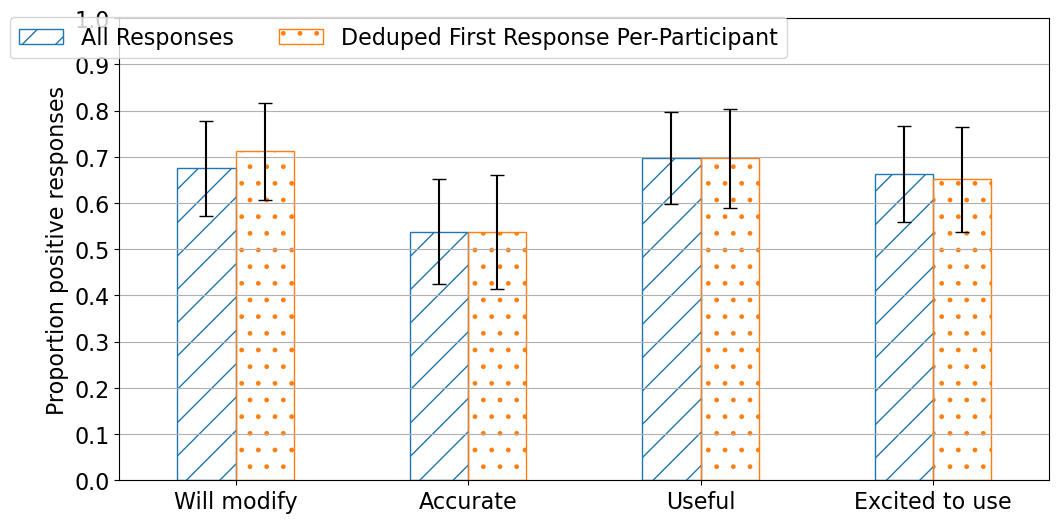

In [16]:
d = get_responses(df_survey, df_survey1, '_question_post', '_question_post')
plot_answers(d, ['All Responses', 'Deduped First Response Per-Participant'])

#### Correlation To Scores Given by LLM

In [19]:
scores = df_checklists[df_checklists.Score >= 0][['submission_id', 'Score', 'Question_Title_Short']]
scores['Score0'] = scores['Score'] == 0
scores['Score1'] = scores['Score'] == 1.
scores['ScoreHalf'] = scores['Score'] == 0.5

n_zeros = scores.groupby('submission_id').Score0.sum()
n_ones = scores.groupby('submission_id').Score1.sum()
n_half = scores.groupby('submission_id').ScoreHalf.sum()

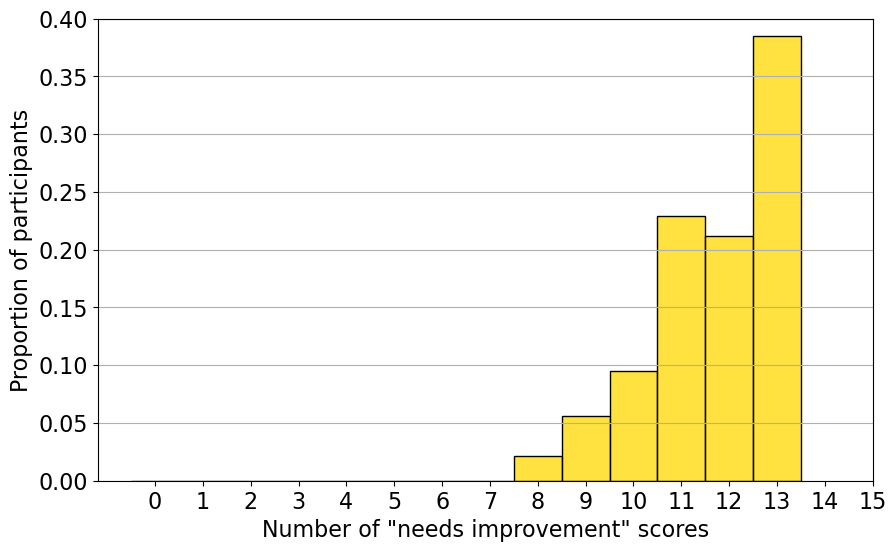

In [20]:
# make two side by sie plots of the half counts and zero counts
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(n_zeros, ax=ax, bins=range(0, 15), color='#FFD700', stat='probability')

ax.set_xlabel("Number of \"needs improvement\" scores", fontsize=16)
a = ax
a.set_ylabel('')
a.set_ylim(0, 0.4)
# a.set_xticks(range(0, 16))
# put ticks in middle of bars
a.set_xticks(np.arange(0.5, 16.5, 1))
a.set_xticklabels(range(0, 16))
ax.set_ylabel('Proportion of participants', fontsize=16)
# add y grid lines
ax.grid(axis='y')

# make x tick and y tick labels larger
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()


In [21]:
df_scores = pd.merge(df_post, n_zeros, on='submission_id')[['submission_id', 'modify_question', 'accurate_question', 'useful_question', 'excited_question', 'Score0']]
df_scores = pd.merge(df_scores, n_half, on='submission_id')
df_scores = pd.merge(df_scores, n_ones, on='submission_id')
df_scores = df_scores.dropna()
for q in QUESTIONS:
    df_scores[q + '_question'] = df_scores[q + '_question'].map(RESPONSE_MAP) > 0

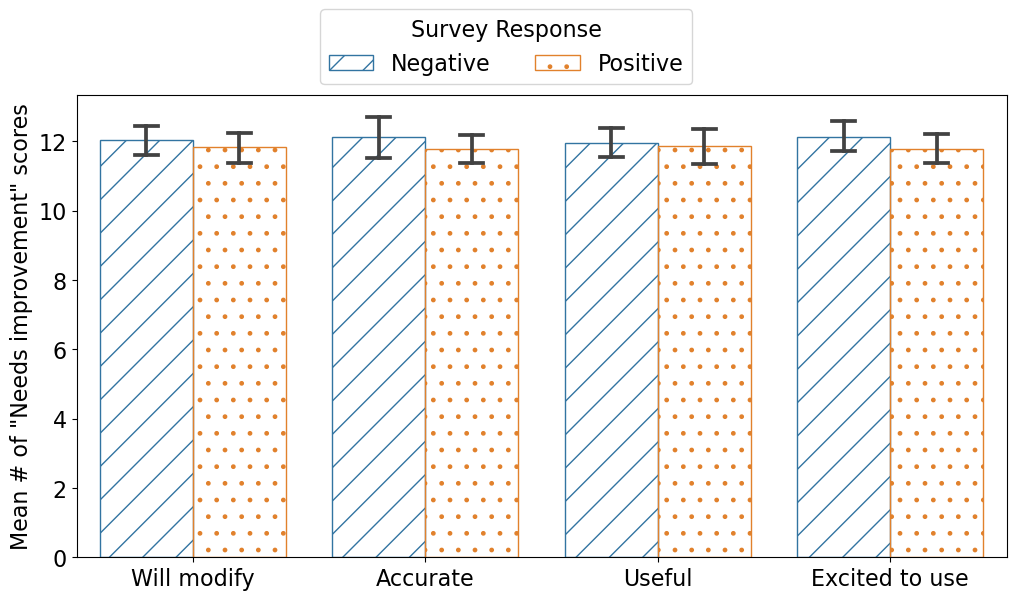

In [22]:
df_melted = pd.melt(df_scores, id_vars=['Score0'], 
                    value_vars=['modify_question', 'useful_question', 'accurate_question', 'excited_question'],
                    var_name='Question', value_name='Response')

# Create the seaborn bar plot
plt.figure(figsize=(12, 6))
p = sns.barplot(data=df_melted, x='Question', y='Score0', hue='Response', errorbar='ci', capsize=0.1)

# Add title and labels
# plt.title('Proportion of `Needs Improvement\' Scores by Survey Response', fontsize=16)
plt.ylabel('Mean # of "Needs improvement\" scores', fontsize=16)
plt.xlabel('')
plt.xticks(range(4), ['Will modify', 'Accurate', 'Useful', 'Excited to use'], fontsize=16)
plt.yticks(fontsize=16)

bars = plt.gca().patches
hatch = ['/', '.']
for bar, h in zip(bars, hatch[0]*4 + hatch[1]*4):
    bar.set_hatch(h)
    # make hatches same color as bar fill and remove bar fill
    bar.set_edgecolor(bar.get_facecolor())
    bar.set_facecolor('none')
# leg = plt.legend(['Negative', 'Positive'], fontsize=14)
# make legend with correct patches
handles, labels = p.get_legend_handles_labels()
plt.legend(handles, ['Negative', 'Positive'], title='Survey Response', fontsize=16, ncol=2, title_fontsize='16', bbox_to_anchor=(0.25, 1.0))


plt.show()

In [23]:
# run a permutation test to see if the number of "needs improvement" scores is different for each survey response
perms = {}
pvalues = {}

for q in QUESTIONS:
    perms[q] = permutation_test((df_melted[(df_melted['Question'] == q+'_question') & df_melted.Response].Score0,
                                df_melted[(df_melted['Question'] == q+'_question') & ~df_melted.Response].Score0),
                                lambda x, y: np.mean(x) - np.mean(y),
                                  n_resamples=50000, alternative='two-sided')
    pvalues[q] = perms[q].pvalue

In [24]:
pvalues

{'modify': 0.6164276714465711,
 'accurate': 0.873262534749305,
 'useful': 0.40439191216175674,
 'excited': 0.4003919921601568}

### Checks for Selection Biases in Pre-Survey Responses 

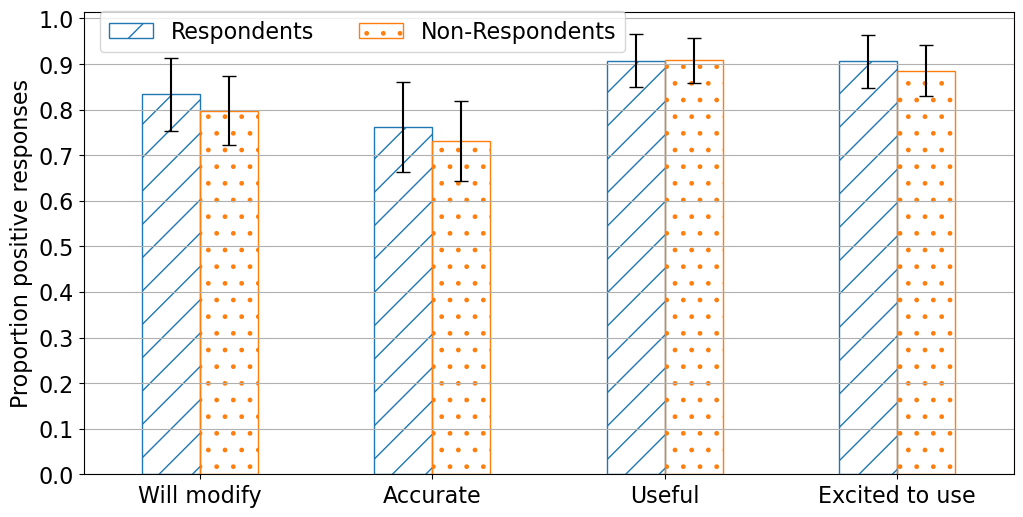

In [25]:
# Compare pre-survey responses of respondents and non-respondents to post-survey (for all participants)
df_survey2 = df_pre[(~df_pre.participant_id.isin(df_survey1.participant_id)) & (df_pre.participant_id.isin(df_sub.participant_id))] # get pre-survey responses that were not joined to post-survey

df_plot = get_responses(df_survey1, df_survey2)
plot_answers(df_plot, ['Respondents', 'Non-Respondents'])

In [26]:
# run permutations tests for each question to check differences between respondents and non respondents
permtests = {}
pvalues = {}

responses_binary = {
    q: {'1': int(r['a1'])*[1] + int(r['n1'] - r['a1'])*[0], '2': int(r['a2'])*[1] + int(r['n2'] - r['a2'])*[0]}
    for q, r in df_plot.iterrows()
}

for q, r in responses_binary.items():
    permtests[q] = result = permutation_test((r['1'], r['2']), 
                          statistic=lambda x, y: np.mean(x) - np.mean(y), 
                          n_resamples=50000, 
                          alternative='two-sided')

    pvalues[q] = permtests[q].pvalue

# apply benjamini-hochberg correction
pvalues = pd.Series(pvalues).sort_values() + np.random.rand(len(pvalues))*1e-10
adjusted_pvalues = pvalues * len(pvalues) / pvalues.rank()

In [27]:
permtests

{'modify': PermutationTestResult(statistic=0.03546099290780147, pvalue=0.7289854202915942, null_distribution=array([ 0.03546099,  0.00967118, -0.04190845, ..., -0.09348807,
         0.06125081, -0.01611863])),
 'accurate': PermutationTestResult(statistic=0.030721966205837115, pvalue=0.8088638227235455, null_distribution=array([-0.04915515, -0.02252944, -0.10240655, ..., -0.02252944,
         0.03072197,  0.08397337])),
 'useful': PermutationTestResult(statistic=-0.00047095761381477086, pvalue=1.0, null_distribution=array([ 0.05070644, -0.02605965, -0.00047096, ..., -0.00047096,
         0.05070644,  0.10188383])),
 'excited': PermutationTestResult(statistic=0.02083333333333337, pvalue=0.8803423931521369, null_distribution=array([-0.08333333,  0.07291667, -0.03125   , ...,  0.02083333,
         0.02083333, -0.00520833]))}

In [28]:
pvalues

modify      0.728985
accurate    0.808864
excited     0.880342
useful      1.000000
dtype: float64

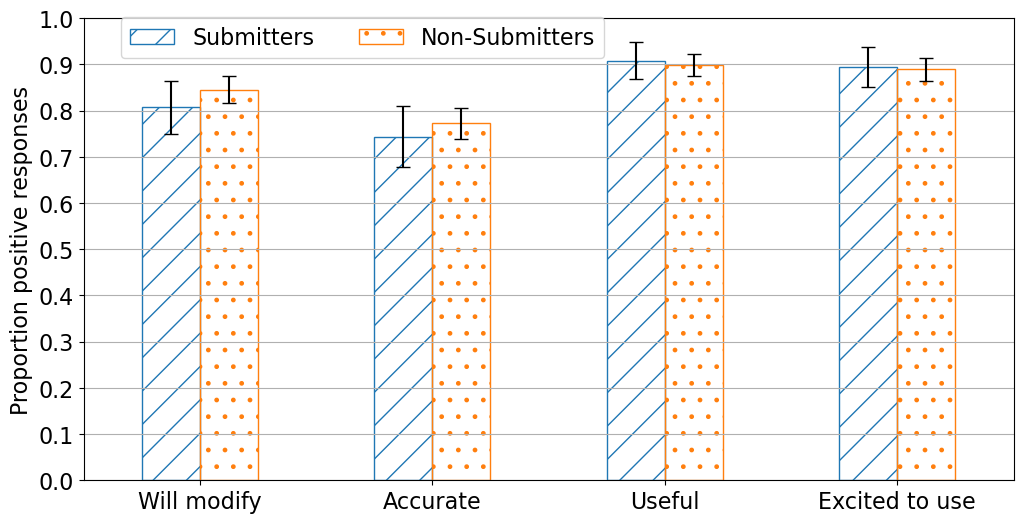

In [29]:
# Compare pre-survey responses of submitters and non-submitters
df_survey1 = df_pre[df_pre.participant_id.isin(df_sub.participant_id)]
df_survey2 = df_pre[~df_pre.participant_id.isin(df_sub.participant_id)]

df_plot = get_responses(df_survey1, df_survey2, q1_str='_question')
plot_answers(df_plot, ['Submitters', 'Non-Submitters'])

In [30]:
# run permutations tests for each question to check differences between respondents and non respondents
permtests = {}
pvalues = {}

responses_binary = {
    q: {'1': int(r['a1'])*[1] + int(r['n1'] - r['a1'])*[0], '2': int(r['a2'])*[1] + int(r['n2'] - r['a2'])*[0]}
    for q, r in df_plot.iterrows()
}

for q, r in responses_binary.items():
    permtests[q] = result = permutation_test((r['1'], r['2']), 
                          statistic=lambda x, y: np.mean(x) - np.mean(y), 
                          n_resamples=50000, 
                          alternative='two-sided')

    pvalues[q] = permtests[q].pvalue

# apply benjamini-hochberg correction
pvalues = pd.Series(pvalues).sort_values() + np.random.rand(len(pvalues))*1e-10
adjusted_pvalues = pvalues * len(pvalues) / pvalues.rank()

In [31]:
permtests

{'modify': PermutationTestResult(statistic=-0.03814802011664087, pvalue=0.2974740505189896, null_distribution=array([ 0.00989105,  0.00989105,  0.04992361, ..., -0.00612197,
         0.00188454,  0.02590408])),
 'accurate': PermutationTestResult(statistic=-0.028973433305563234, pvalue=0.5188696226075479, null_distribution=array([-0.04540405, -0.03718874,  0.00388781, ..., -0.02075812,
        -0.02075812, -0.07004999])),
 'useful': PermutationTestResult(statistic=0.00993518676445504, pvalue=0.8466630667386652, null_distribution=array([ 0.00208937,  0.017781  ,  0.04916425, ...,  0.017781  ,
         0.04131844, -0.00575644])),
 'excited': PermutationTestResult(statistic=0.004926871934544552, pvalue=0.9783804323913522, null_distribution=array([-0.02704797, -0.01106055, -0.00306684, ...,  0.06887656,
        -0.02704797,  0.02091429]))}

In [32]:
pvalues

modify      0.297474
accurate    0.518870
useful      0.846663
excited     0.978380
dtype: float64

# Analyze Resubmissions

### Get Multiple Submissions to the LLM

In [33]:
# assign paper_id to each paper based on its title (across multiple versions of the paper)
df_sub['ts_submission_dt'] = pd.to_datetime(df_sub['ts_submission'])
title_map = {t: i for i,t in enumerate(df_sub['title'].unique())}
df_sub['paper_id'] = df_sub['title'].map(title_map)

# # Check if anyone submitted multiple papers with different titles
# for p in df_sub['participant_id'].unique():
#     df_p = df_sub[df_sub['participant_id'] == p]
#     n_submissions = df_p.shape[0]
#     n_papers = df_p.title.nunique()
#     if n_papers > 1:
#         # print(df_p.title.unique())
#         # print(df_p.submission_id.unique())

# Manually pair submissions from the same participant where title changed slightly but paper is the same
changed_title_submissions = [
    [62216, 61501],
    [62185, 61491],
    [61911, 61604],
    [61829, 61447],
    [61808, 60941],
    [61749, 60630]
]

for sub1, sub2 in changed_title_submissions:
    df_sub.loc[df_sub['submission_id'] == sub2, 'paper_id'] = df_sub.loc[df_sub['submission_id'] == sub1, 'paper_id'].values[0]

In [34]:
# get number of papers with multiple submissions
n_submissions = df_sub[['paper_id', 'participant_id']].value_counts()
multiple_submissions = n_submissions[n_submissions > 1]
len(multiple_submissions)

43

In [35]:
len(n_submissions), df_sub.paper_id.nunique()

(184, 182)

Note that there was one paper where two different authors submitted the same paper and they each submitted it twice.  

In [36]:
# Get first two submissions for each paper with multiple submissions 
# (assuming that the first two submissions are the first two versions of the paper)
submission_pairs = df_sub[df_sub['paper_id'].isin(multiple_submissions.index.get_level_values(0))].groupby(['paper_id', 'participant_id'])
# sort by ts_submission and take first 2
submission_pairs = submission_pairs.apply(lambda x: x.sort_values('ts_submission_dt').head(2)).reset_index(drop=True)

In [39]:
# get gap in time between first and second submissions
gap_resubmit_hrs = submission_pairs.groupby('paper_id').apply(lambda x: x['ts_submission_dt'].diff().dt.total_seconds().iloc[1]) / (60*60)
# get papers with gap less than 1 hour
list(gap_resubmit_hrs[gap_resubmit_hrs < 1].values)

[0.5833333333333334, 0.8, 0.75, 0.9166666666666666]

All resubmissions to the server were made at least 30 mins after the first, with 39 / 43 made over an hour after the first.

In [40]:
def get_checklist_changes(pair):
    pair = pair.reset_index(drop=True) 
    # get checklist for each submission
    zip_path1 = f"{pair['zip_name'][0]}"
    zip_path2 = f"{pair['zip_name'][1]}"
    checklist1 = extract_checklist(zip_path1.strip())
    checklist2 = extract_checklist(zip_path2.strip())
    merged = pd.merge(checklist1, checklist2, on=['Question', 'Question_Title', 'Guidelines'], suffixes=('_1', '_2'))
    if merged[(merged.Answer_1 == 'Not Found') | (merged.Answer_2 == 'Not Found')].shape[0] > 0:
        print('No checklist found for some questions in one of the submissions on paper.')
        return None 
    assert(merged.shape[0] == checklist1.shape[0] == checklist2.shape[0])
    assert(merged.LLM_1.equals(merged.LLM_2))
    merged.drop(columns=['LLM_1', 'LLM_2'], inplace=True)
    return merged

In [42]:
all_changes = pd.DataFrame()
for paper_id in submission_pairs.paper_id.unique():
    pair = submission_pairs[submission_pairs['paper_id'] == paper_id]
    changes = get_checklist_changes(pair)
    if changes is None:
        continue
    changes['paper_id'] = paper_id
    all_changes = pd.concat([all_changes, changes])

No checklist found for some questions in one of the submissions on paper.
No checklist found for some questions in one of the submissions on paper.


In [43]:
all_changes.paper_id.nunique()

40

In [44]:
all_changes['changed_answer'] = all_changes.Answer_1 != all_changes.Answer_2
all_changes['changed_justification'] = all_changes.Justification_1 != all_changes.Justification_2
changed_answers = all_changes[all_changes.Answer_1 != all_changes.Answer_2]

In [45]:
# get number of papers with changed answers and justifications
all_changes.groupby('paper_id')[['changed_answer', 'changed_justification']].max().sum()

changed_answer           22
changed_justification    39
dtype: int64

In [50]:
# replace 0.5 with 0 in  Score 1 and Score 2
all_changes['Score_1'] = all_changes['Score_1'].replace(0.5, 0)
all_changes['Score_2'] = all_changes['Score_2'].replace(0.5, 0) 
all_changes['Score_2'] = all_changes['Score_2'].replace(-1., 0) 
all_changes['score_diff'] = all_changes['Score_2'] - all_changes['Score_1']


In [51]:
def compute_score_change(df):
    score_diff_nochanges = df[(~df.changed_answer) & ~(df.changed_justification)].score_diff.value_counts(normalize=True).sort_index()
    score_diff_change_answers = df[(df.changed_answer)].score_diff.value_counts(normalize=True).sort_index()
    score_diff_change_justifications = df[~(df.changed_answer) & (df.changed_justification)].score_diff.value_counts(normalize=True).sort_index()
    return score_diff_nochanges, score_diff_change_answers, score_diff_change_justifications

In [52]:
def resample_papers(df):
    papers = df.paper_id.unique()
    papers_resampled = np.random.choice(papers, size=len(papers), replace=True)
    return pd.concat([df[df.paper_id == p].reset_index() for p in papers_resampled])

# bootstrap confidence intervals for score changes
def bootstrap_score_change(df, n_iter=1000, alpha=0.05):
    score_diff_nochanges = []
    score_diff_change_answers = []
    score_diff_change_justifications = []
    for i in range(n_iter):
        sample = resample_papers(df)
        nochanges, change_answers, change_justifications = compute_score_change(sample)
        score_diff_nochanges.append(nochanges)
        score_diff_change_answers.append(change_answers)
        score_diff_change_justifications.append(change_justifications)
    score_diff_nochanges = pd.concat(score_diff_nochanges, axis=1).T
    score_diff_change_answers = pd.concat(score_diff_change_answers, axis=1).T
    score_diff_change_justifications = pd.concat(score_diff_change_justifications, axis=1).T
    score_diff_nochanges = score_diff_nochanges.quantile([alpha/2, 1-alpha/2])
    score_diff_change_answers = score_diff_change_answers.quantile([alpha/2, 1-alpha/2])
    score_diff_change_justifications = score_diff_change_justifications.quantile([alpha/2, 1-(alpha/2)])
    return score_diff_nochanges, score_diff_change_answers, score_diff_change_justifications



In [53]:
score_diff_nochanges_lims, score_diff_change_answers_lims, score_diff_change_justifications_lims = bootstrap_score_change(all_changes, n_iter=10000)
score_diff_nochanges, score_diff_change_answers, score_diff_change_justifications = compute_score_change(all_changes)

In [54]:
score_diff_nochanges_err = [(score_diff_nochanges - score_diff_nochanges_lims).T[0.025], (score_diff_nochanges_lims - score_diff_nochanges).T[0.975]]
score_diff_change_answers_err = [(score_diff_change_answers - score_diff_change_answers_lims).T[0.025], (score_diff_change_answers_lims - score_diff_change_answers).T[0.975]]
score_diff_change_justifications_err = [(score_diff_change_justifications - score_diff_change_justifications_lims).T[0.025], (score_diff_change_justifications_lims - score_diff_change_justifications).T[0.975]]

In [55]:
score_diff_nochanges, score_diff_change_justifications, score_diff_change_answers

(score_diff
 -1.0    0.119149
  0.0    0.808511
  1.0    0.072340
 Name: proportion, dtype: float64,
 score_diff
 -1.0    0.046440
  0.0    0.820433
  1.0    0.133127
 Name: proportion, dtype: float64,
 score_diff
 -1.0    0.023810
  0.0    0.833333
  1.0    0.142857
 Name: proportion, dtype: float64)

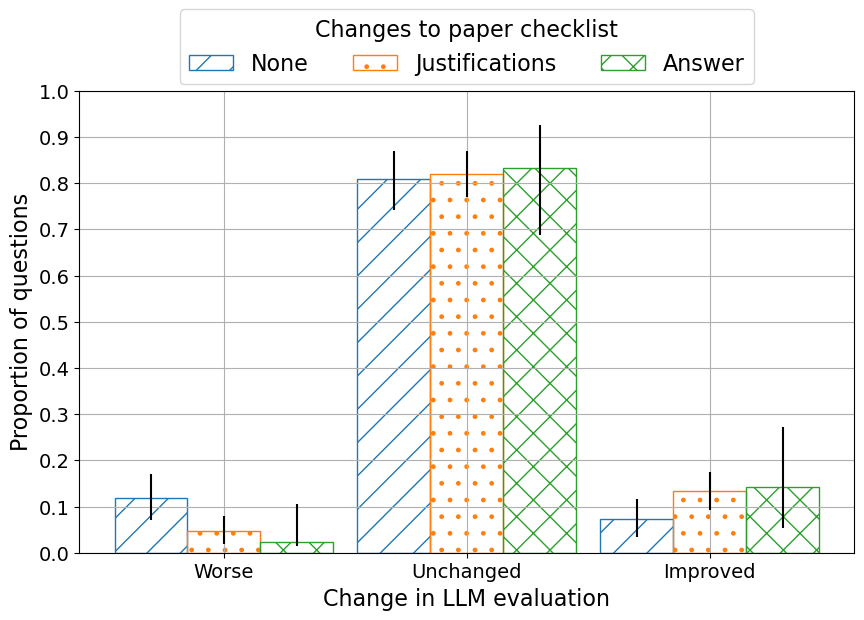

In [56]:
# plot the three distributions on one plot staggered
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.3
x = np.arange(-1, 2)
ax.bar(x - width, score_diff_nochanges, width, label='None', yerr=score_diff_nochanges_err)
ax.bar(x, score_diff_change_justifications, width, label='Justifications', yerr=score_diff_change_justifications_err)
ax.bar(x+width, score_diff_change_answers, width, label='Answer', yerr=score_diff_change_answers_err)
ax.set_xlabel('Change in LLM evaluation', fontsize=16)
# make three x ticks for each score change
ax.set_xticks(x)
ax.set_xticklabels(['Worse', 'Unchanged', 'Improved'], fontsize=15)
# set y ticks to be in 0.1 increments
ax.set_yticks(np.arange(0,1.1,0.1))
# make y ticks larger and only print one decimal place
ax.set_yticklabels(np.round(np.arange(0,1.1,0.1), 1), fontsize=15)

bars = plt.gca().patches
hatch = ['/', '.', 'x']
for bar, h in zip(bars, hatch[0]*3 + hatch[1]*3 + hatch[2]*3):
    bar.set_hatch(h)
    # make hatches same color as bar fill and remove bar fill
    bar.set_edgecolor(bar.get_facecolor())
    bar.set_facecolor('none')
# leg = plt.legend(['Expectations', 'Post-Usage'], fontsize=12, handlelength=2, ncol=2)

# add y grid lines
plt.grid(axis='y')
# add x grid lins
plt.grid(axis='x')

ax.set_ylabel('Proportion of questions', fontsize=16)
plt.legend(title='Changes to paper checklist', fontsize=16, loc='upper center', ncol = 3, bbox_to_anchor=(0.5, 1.2))
# make legend title fontsize bigger
plt.setp(ax.get_legend().get_title(), fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Analyze Change in Word Count between Resubmissions 

In [57]:
# Check for changes in answers to checklist questions
answer_changes = all_changes[all_changes['Answer_1'] != all_changes['Answer_2']]
n_answers = len(answer_changes)
n_papers = answer_changes.paper_id.nunique()

# Check for changes in justifications to checklist questions
justification_changes = all_changes[all_changes['Justification_1'] != all_changes['Justification_2']].reset_index(drop=True)

In [58]:
len(justification_changes)

362

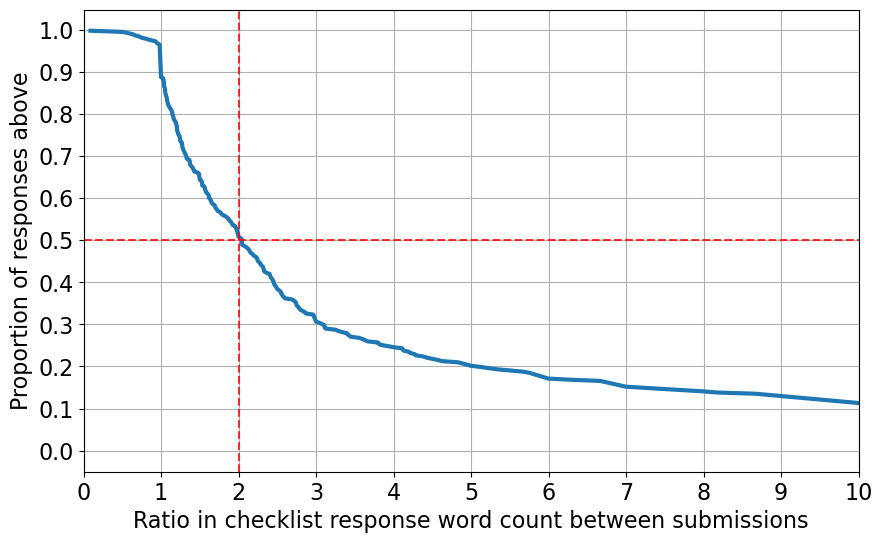

In [59]:
def get_word_count(s):
    return len(s.split())

justification_changes['word_count_1'] = [get_word_count(str(s)) for s in justification_changes['Justification_1']]
justification_changes['word_count_2'] = [get_word_count(str(s)) for s in justification_changes['Justification_2']]

justification_changes['word_count_change'] = justification_changes['word_count_2'] / justification_changes['word_count_1']

# plot cdf of word count change
word_count_change = justification_changes['word_count_change'].clip(0,11)
# word_count_change = word_count_change[~word_count_change.isna()]
# word_count_change = word_count_change.sort_values()
# word_count_change = np.cumsum(word_count_change.value_counts(normalize=True).sort_index())
# plt.plot(word_count_change.index, word_count_change)



# # plot distribution of word count change
fig, ax = plt.subplots(figsize=(10, 6))
# change to CDF 
# sns.histplot((justification_changes['word_count_change']), bins=np.arange(0, 10, 1), color='blue', stat='probability')
# plot CDF 
word_count_change = 1. - word_count_change.value_counts(normalize=True).sort_index().cumsum()
plt.plot(word_count_change.index, word_count_change, lw=3)

plt.xlim(0, 10)
plt.xlabel('Ratio in checklist response word count between submissions', fontsize=16)
plt.xticks(range(0,11,1), fontsize=16)
plt.ylabel('Proportion of responses above', fontsize=16)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=16)
# put dotted line at 1
plt.axvline(2, color='red', ls='--', alpha=0.8)
plt.axhline(0.5, color='red', ls='--', alpha=0.8)
# add grid 
plt.grid(True)

plt.show()


